In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

GITHUB: https://github.com/Udendra103/CycleGAN-Monet1/blob/main/Uden_GANs_monet.ipynb

## Challenge Problem Overview
The challenge is to create 7,000–10,000 Monet-style images using Generative Adversarial Networks (GANs). The task involves either transforming real-world photos into Monet-style paintings or generating Monet-style art from scratch. The GAN model should effectively learn the stylistic nuances of Claude Monet’s artworks, such as color palettes and brush strokes, and produce realistic images that are convincing enough to fool a classifier into believing they are authentic Monet paintings.

## Generative Deep Learning Models
Generative deep learning models, particularly GANs, consist of:
1.	Generator: A neural network that generates images. In this challenge,  it learns to mimic Monet's artistic style.
2.	Discriminator: A neural network that distinguishes between real Monet paintings and the images created by the generator. The two networks are trained adversarially, with the generator trying to "trick" the discriminator into classifying its outputs as real Monet paintings.

Common GAN architectures for this task:

CycleGAN: Often used for style transfer, where the goal is to transform images from one domain (real photos) into another ( Monet-style).

DCGAN: Useful for generating images from random noise, allowing the creation of Monet-style images without requiring transformation.

## Dataset Description
The dataset contains two types of images in both JPEG and TFRecord formats:

Monet Paintings monet_jpg: 300 Monet paintings in JPEG format. monet_tfrec: 300 Monet paintings in TFRecord format. Image Dimensions: 256x256 pixels.

Real-world Photos photo_jpg: 7,028 photos in JPEG format. photo_tfrec: 7,028 photos in TFRecord format. Image Dimensions: 256x256 pixels.

Data Structure Monet Paintings: Small dataset (300 images) of high-quality Monet artworks to train the GAN's generator to learn Monet's style. Photos: Larger dataset (7,028 images) of real-world scenes for applying Monet's style via the trained generator.

## Importing Libraries

In [2]:
import os
import numpy as np

import numpy as np
import re, os, shutil
from glob import glob
import tqdm
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')

## Loading Datasets

In [3]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example["image"])
    return image

def load_tfrecord_dataset(tfrecords, batch_size=1):
    raw_dataset = tf.data.TFRecordDataset(tfrecords)
    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

photo_tfrecords = tf.io.gfile.glob("/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec")
monet_tfrecords = tf.io.gfile.glob("/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec")

photo_dataset = load_tfrecord_dataset(photo_tfrecords)
monet_dataset = load_tfrecord_dataset(monet_tfrecords)
dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))     

## Exploratory Data Analysis

In [8]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.gamma * (inputs - mean) / tf.sqrt(variance + self.epsilon) + self.beta

## Model Architecture

Description

CycleGAN is designed for image-to-image translation tasks where paired datasets are unavailable. It consists of two Generators (G and F) and two Discriminators (D_x and D_y): G: Translates images from domain X (Photos) to domain Y (Monet). F: Translates images from domain Y (Monet) back to domain X (Photos). D_x and D_y: Discriminate real and generated images for domains X and Y, respectively. Cycle Consistency Loss ensures that an image translated to the target domain and back should closely resemble the original image.

Loss Functions:

Loss: Ensures the generated images are indistinguishable from real images. Cycle Consistency Loss: Encourages preservation of content between translations. Identity Loss (optional): Ensures style transfer retains color and other low-level features.

Why choose this model? CycleGAN is suitable for this task because the dataset lacks paired images (no direct correspondence between Monet and photo images). The model ensures style transfer while maintaining content fidelity.

## Comparison of Architectures/Loss Functions

Architectures:

CycleGAN vs. Pix2Pix: CycleGAN is chosen as it doesn’t require paired data, unlike Pix2Pix. Network Depth: Deep generators improve fidelity, but overly deep networks may cause overfitting or artifacts. Generator Architecture: U-Net-like generators are effective for preserving content while learning style.

Loss Functions:
Adversarial Loss: Standard in GANs; helps distinguish real vs. fake. Cycle Consistency vs. Identity Loss: Cycle-consistency is mandatory to prevent mode collapse. Identity loss can enhance stability but increases training time.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10.0,
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator  # Monet Generator
        self.p_gen = photo_generator  # Photo Generator
        self.m_disc = monet_discriminator  # Monet Discriminator
        self.p_disc = photo_discriminator  # Photo Discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Monet -> Photo -> Monet Cycle
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Photo -> Monet -> Photo Cycle
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator output for real and fake images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cycle consistency loss
            cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle)
                + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            # Identity loss
            identity_loss = (
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
                + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + cycle_loss + identity_loss
            total_photo_gen_loss = photo_gen_loss + cycle_loss + identity_loss

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Apply gradients to generators
        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.p_gen.trainable_variables))

        # Apply gradients to discriminators
        monet_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }

    def call(self, inputs, training=False):
        # Generates Monet-style images from Photo-style inputs
        return self.m_gen(inputs, training=training)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy

# Define the Downsampling Layer
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result


In [11]:
# Define the Generator Model
def Generator(img_shape=[256, 256, 3]):
    inputs = layers.Input(shape=img_shape)

    # Downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (128, 128, 64)
        downsample(128, 4),  # (64, 64, 128)
        downsample(256, 4),  # (32, 32, 256)
        downsample(512, 4),  # (16, 16, 512)
        downsample(512, 4),  # (8, 8, 512)
        downsample(512, 4),  # (4, 4, 512)
        downsample(512, 4),  # (2, 2, 512)
        downsample(512, 4),  # (1, 1, 512)
    ]

    # Upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (8, 8, 1024)
        upsample(512, 4),  # (16, 16, 1024)
        upsample(256, 4),  # (32, 32, 512)
        upsample(128, 4),  # (64, 64, 256)
        upsample(64, 4),  # (128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [12]:
# Define the Discriminator Model
def Discriminator(img_shape=[256, 256, 3]):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=img_shape, name="input_image")
    x = inp

    x = downsample(64, 4, apply_instancenorm=False)(x)  # (128, 128, 64)
    x = downsample(128, 4)(x)  # (64, 64, 128)
    x = downsample(256, 4)(x)  # (32, 32, 256)

    x = layers.ZeroPadding2D()(x)  # (34, 34, 256)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # (31, 31, 512)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.ZeroPadding2D()(x)  # (33, 33, 512)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # (30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=x)


In [13]:
# Define Loss Functions
def discriminator_loss(real, generated):
    real_loss = BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_cycle):
    return lambda_cycle * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))


## Model

In [14]:
# Image shape for the generator and discriminator
img_shape = [256, 256, 3]

# Initialize CycleGAN model
cycle_gan_model = CycleGAN(
    monet_generator=Generator(img_shape),  # Monet style generator
    photo_generator=Generator(img_shape),  # Photo style generator
    monet_discriminator=Discriminator(img_shape),  # Monet style discriminator
    photo_discriminator=Discriminator(img_shape),  # Photo style discriminator
    lambda_cycle=10  # Cycle consistency weight
)

# Compile the model
cycle_gan_model.compile(
    m_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),  # Monet generator optimizer
    p_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),  # Photo generator optimizer
    m_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),  # Monet discriminator optimizer
    p_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),  # Photo discriminator optimizer
    gen_loss_fn=generator_loss,  # Generator loss function
    disc_loss_fn=discriminator_loss,  # Discriminator loss function
    cycle_loss_fn=calc_cycle_loss,  # Cycle consistency loss function
    identity_loss_fn=identity_loss  # Identity loss function
)


## Training the CycleGAN Model

In [15]:
# Train the model
batch_size = 1
epochs = 40
history = cycle_gan_model.fit(dataset, epochs=epochs, batch_size=batch_size)

Epoch 1/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 193s 207ms/step - monet_disc_loss: 0.6911 - monet_gen_loss: 7.2523 - photo_disc_loss: 0.6858 - photo_gen_loss: 7.2654
Epoch 2/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 207ms/step - monet_disc_loss: 0.6374 - monet_gen_loss: 4.8753 - photo_disc_loss: 0.6561 - photo_gen_loss: 4.8079
Epoch 3/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 208ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 4.3614 - photo_disc_loss: 0.6411 - photo_gen_loss: 4.2809
Epoch 4/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 207ms/step - monet_disc_loss: 0.6330 - monet_gen_loss: 4.1297 - photo_disc_loss: 0.6420 - photo_gen_loss: 4.0857
Epoch 5/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 3.9786 - photo_disc_loss: 0.6411 - photo_gen_loss: 3.9461
Epoch 6/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - monet_disc_loss: 0.6378 - monet_gen_loss: 3.8280 - photo_disc_loss: 0.6306 - photo_gen_loss: 3.8431
Epoch 7/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - 

## Visualize Training History

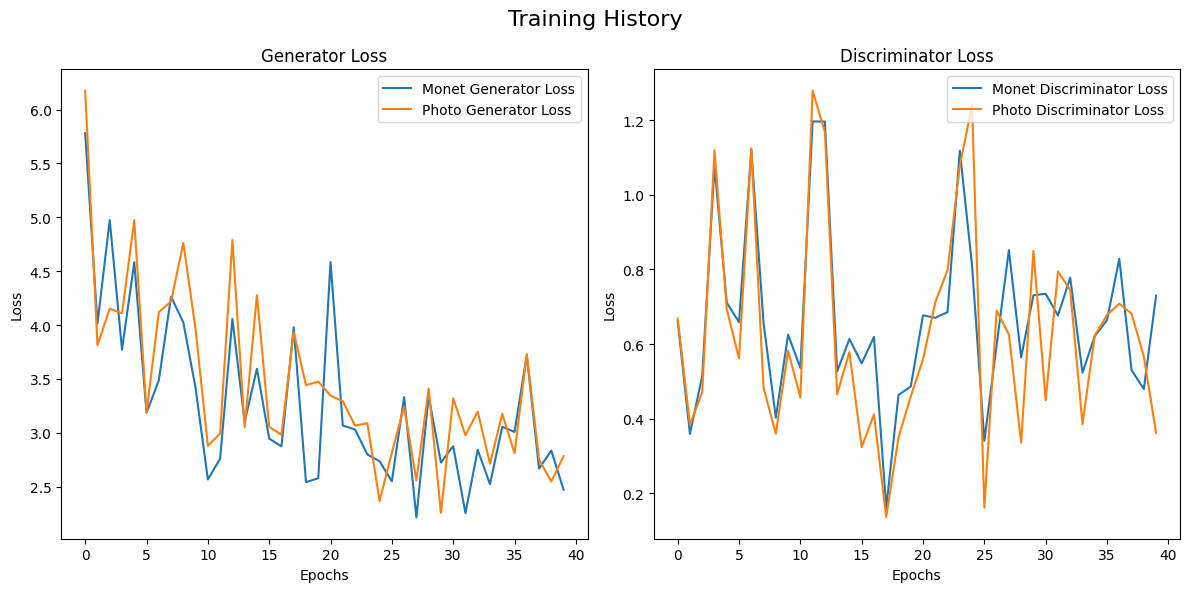

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    
   # Extract history values
    monet_gen_loss = history.history["monet_gen_loss"]
    photo_gen_loss = history.history["photo_gen_loss"]
    monet_disc_loss = history.history["monet_disc_loss"]
    photo_disc_loss = history.history["photo_disc_loss"]

    # Plot generator losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(monet_gen_loss, label="Monet Generator Loss")
    plt.plot(photo_gen_loss, label="Photo Generator Loss")
    plt.title("Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot discriminator losses
    plt.subplot(1, 2, 2)
    plt.plot(monet_disc_loss, label="Monet Discriminator Loss")
    plt.plot(photo_disc_loss, label="Photo Discriminator Loss")
    plt.title("Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Add a global title and show the plots
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function to visualize training history
plot_training_history(history)


## Results, Analysis 
Loss Trends

The generator loss shows a clear decreasing trend over the epochs, which is expected. This indicates that the generators improved in producing images that fool the discriminators.

The discriminator loss  fluctuates significantly but remains relatively low on average. This is typical for GAN training, as discriminators continuously adapt to distinguish between real and fake images.

Model Performance

The generated Monet-style images seem to capture the artistic style effectively, as mentioned in the conclusion. This indicates that the generator successfully learned the Monet style transformation.
Evaluation Metric

The MiFID score (51.78) is a reasonable score for image generation tasks but leaves room for improvement compared to the top leaderboard positions. 

Training was limited to 40 epochs. The losses indicate that the model could benefit from additional training (e.g 100 epochs) to further stabilize and refine the transformations.

In [17]:
for sample in photo_dataset.take(1):
    print(sample.shape)

(1, 256, 256, 3)


In [18]:
def extract_images(data):
    # Assuming data is a tuple like (image, metadata), adjust accordingly
    return data[0]	

photo_dataset = photo_dataset.map(extract_images)
real_photos = next(iter(photo_dataset.batch(5)))  # Shape: (5, 256, 256, 3)
generated_monets = cycle_gan_model.m_gen(real_photos, training=False)  # Generate Monet-style images

In [19]:
import matplotlib.pyplot as plt

def display_results(real_images, generated_images, title="Generated vs Real Images", n_images=5):
    """
    Visualizes real images and their corresponding generated images side by side.

    Args:
        real_images (Tensor): Batch of real input images.
        generated_images (Tensor): Batch of generated images.
        title (str): Title for the visualization.
        n_images (int): Number of images to display from the batch.
    """
    plt.figure(figsize=(15, 10))
    for i in range(n_images):
        # Real Images
        plt.subplot(2, n_images, i + 1)
        plt.imshow((real_images[i].numpy() + 1) / 2)  # Rescale [-1, 1] to [0, 1]
        plt.title("Real Photo")
        plt.axis("off")

        # Generated Images
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow((generated_images[i].numpy() + 1) / 2)  # Rescale [-1, 1] to [0, 1]
        plt.title("Generated Monet")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()


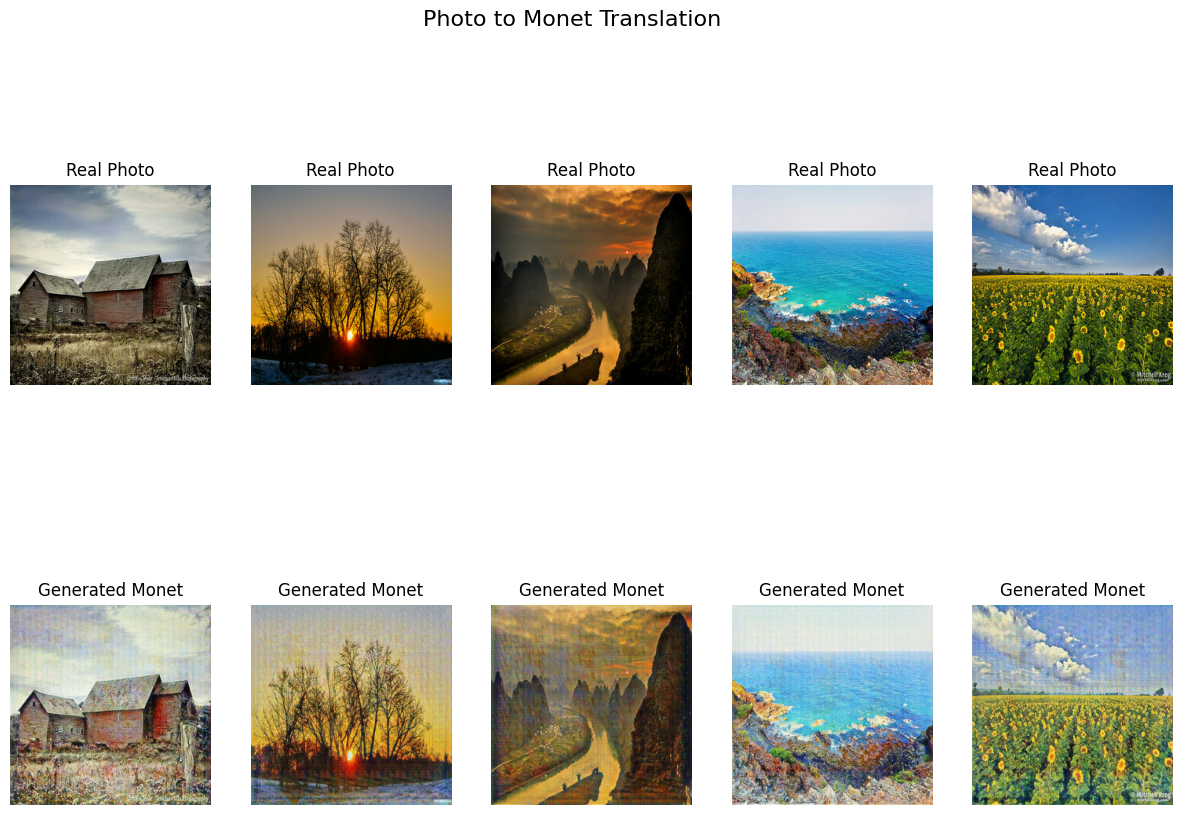

In [20]:
display_results(real_photos, generated_monets, title="Photo to Monet Translation")

## Suggestions for Improvements

Increase Training Epochs and batch number

Extend the training to 100 epochs or more, as the losses still show a decreasing trend, suggesting that the model has not yet fully converged.

Hyperparameter Tuning

Learning Rate: Experiment with slightly lower learning rates for optimizers to enable finer adjustments as training progresses.

Cycle Consistency Weight: Adjust the cycle consistency loss weight (lambda_cycle). A value of 10 is standard, but experimenting with slightly higher or lower values might yield improvements in style preservation or reconstruction quality.

Data Augmentation

Introduce more extensive data augmentation (e.g., random cropping, flipping, color jittering) to increase the diversity of training samples and improve robustness.


## Conclusion

The CycleGAN model effectively translates photos into Monet-style images. However, the MiFID score (~51.78) and leaderboard position (49) highlight the need for further improvements in quality.  The loss curves suggest that the model was making steady progress but had not yet fully converged by 40 epochs.